Files already downloaded and verified
Files already downloaded and verified
ship


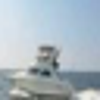

In [1]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
show = ToPILImage() # 可以把Tensor转成Image，方便可视化


# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
    transforms.ToTensor(), # 转为Tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
])

# 训练集
trainset = tv.datasets.CIFAR10(
    root='D:/res',
    train=True,
    download=True,
    transform=transform)

trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
    'D:/res',
    train=False,
    download=True,
    transform=transform)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

      truck       plane       horse       truck


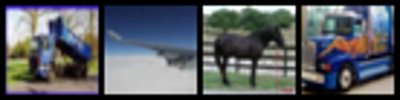

In [2]:
dataiter = iter(trainloader)
images, labels = dataiter.next() # 返回4张图片及标签
print(' '.join('%11s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [4]:
from torch import optim
criterion = nn.CrossEntropyLoss() # 交叉熵损失函数
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
t.set_num_threads(6)
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):

        # 输入数据
        inputs, labels = data

        # 梯度清零
        optimizer.zero_grad()

        # forward + backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # 更新参数
        optimizer.step()

        # 打印log信息
        # loss 是一个scalar,需要使用loss.item()来获取数值，不能使用loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # 每2000个batch打印一下训练状态
            print('[%d, %5d] loss: %.3f'
                  % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.221
[1,  4000] loss: 1.867
[1,  6000] loss: 1.664
[1,  8000] loss: 1.560
[1, 10000] loss: 1.496
[1, 12000] loss: 1.472
[2,  2000] loss: 1.378
[2,  4000] loss: 1.370
[2,  6000] loss: 1.326
[2,  8000] loss: 1.303
[2, 10000] loss: 1.289
[2, 12000] loss: 1.267
Finished Training


实际的label:       cat     ship     ship    plane


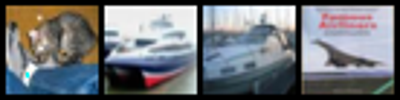

In [6]:
dataiter = iter(testloader)
images, labels = dataiter.next() # 一个batch返回4张图片
print('实际的label: ', ' '.join(
    '%08s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid(images / 2 - 0.5)).resize((400,100))

In [7]:
# 计算图片在每个类别上的分数
outputs = net(images)
# 得分最高的那个类
_, predicted = t.max(outputs.data, 1)

print('预测结果: ', ' '.join('%5s'
                         % classes[predicted[j]] for j in range(4)))

预测结果:    cat plane  ship plane


In [8]:
correct = 0 # 预测正确的图片数
total = 0 # 总共的图片数


# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with t.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('10000张测试集中的准确率为: %d %%' % (100 * correct / total))

10000张测试集中的准确率为: 56 %


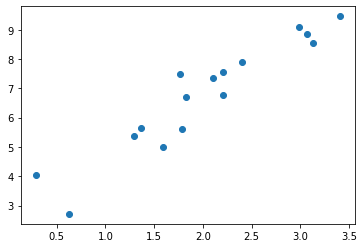

In [1]:
# import os

import torch as t
%matplotlib inline
from matplotlib import pyplot as plt
from IPython import display

# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = t.device('cpu') #如果你想用gpu，改成t.device('cuda:0')
# 设置随机数种子，保证在不同电脑上运行时下面的输出一致
t.manual_seed(1000)

def get_fake_data(batch_size=8):
    ''' 产生随机数据：y=x*2+3，加上了一些噪声'''
    x = t.rand(batch_size, 1, device=device) * 5
    y = x * 2 + 3 +  t.randn(batch_size, 1, device=device)
    return x, y

# 来看看产生的x-y分布
x, y = get_fake_data(batch_size=16)
plt.scatter(x.squeeze().cpu().numpy(), y.squeeze().cpu().numpy())


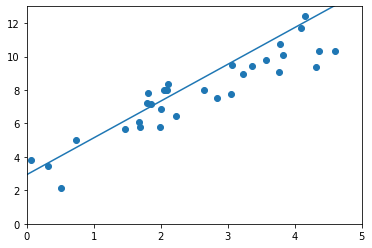

w:  1.9115010499954224 b:  3.044184446334839


In [2]:
# 随机初始化参数
w = t.rand(1, 1).to(device)
b = t.zeros(1, 1).to(device)

lr =0.02 # 学习率

for ii in range(500):
    x, y = get_fake_data(batch_size=4)

    # forward：计算loss
    y_pred = x.mm(w) + b.expand_as(y) # x@W等价于x.mm(w);for python3 only
    loss = 0.5 * (y_pred - y) ** 2 # 均方误差
    loss = loss.mean()

    # backward：手动计算梯度
    dloss = 1
    dy_pred = dloss * (y_pred - y)

    dw = x.t().mm(dy_pred)
    db = dy_pred.sum()

    # 更新参数
    w.sub_(lr * dw)
    b.sub_(lr * db)

    if ii%50 ==0:

        # 画图
        display.clear_output(wait=True)
        x = t.arange(0, 6).view(-1, 1)
        y = x.float().mm(w) + b.expand_as(x)
        plt.plot(x.cpu().numpy(), y.cpu().numpy()) # predicted

        x2, y2 = get_fake_data(batch_size=32)
        plt.scatter(x2.numpy(), y2.numpy()) # true data

        plt.xlim(0, 5)
        plt.ylim(0, 13)
        plt.show()
        plt.pause(0.5)

print('w: ', w.item(), 'b: ', b.item())